In [1]:
# System
import os
from collections import defaultdict, Counter
from itertools import zip_longest
import csv
import re
import progressbar
import shutil

# Data Analysis
import pandas
import tabulate
import seaborn
import numpy
import matplotlib.pyplot as plt
import matplotlib as mpl

# From imports
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle

# Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Short hack for display of images in jupyter notebook

from IPython.display import display, HTML
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))

In [2]:
FIGS_DIR = "figs"
PAPER_DIR = '/mnt/e/repositories/github/MATApaper/submission/figs'
def save_figure(fig, ext=".png"):
    """Stores @p fig at `figs/fig.@ext`"""
    tgt_dir = os.path.join(DATA_SOURCE, FIGS_DIR)
    tgt = os.path.join(tgt_dir, fig + ext)    
    if not os.path.exists(tgt_dir):
        os.makedirs(tgt_dir)
    print(f"Saving to {tgt}")
    if ext == ".png":
        plt.savefig(tgt, backend="cairo", bbox_inches="tight", pad_inches=0.2)
    elif ext == '.pdf':
        plt.savefig(tgt, format='pdf', bbox_inches="tight", pad_inches=0.2)
        shutil.copy(tgt, PAPER_DIR)
    else:
        plt.savefig(tgt, bbox_inches="tight", pad_inches=0.2)

In [3]:
DATA_DIR = "./data/"
for experiment_dir in os.listdir(DATA_DIR):
    full_path = os.path.join(DATA_DIR, experiment_dir)
    if os.path.isdir(full_path):
        print(f'DATA_SOURCE = "{full_path}"')

DATA_SOURCE = "./data/experiments-09-18"
DATA_SOURCE = "./data/experiments-09-19"
DATA_SOURCE = "./data/experiments-09-21"
DATA_SOURCE = "./data/experiments-09-23"
DATA_SOURCE = "./data/experiments-09-25-concat"
DATA_SOURCE = "./data/experiments-09-26-partial-testing"
DATA_SOURCE = "./data/experiments-09-27"
DATA_SOURCE = "./data/experiments-09-29-new-mata"
DATA_SOURCE = "./data/experiments-09-30-parsing"
DATA_SOURCE = "./data/experiments-10-01-mata-union"
DATA_SOURCE = "./data/experiments-10-02"
DATA_SOURCE = "./data/experiments-10-02-automata"
DATA_SOURCE = "./data/experiments-10-02-parsing"
DATA_SOURCE = "./data/experiments-10-04"
DATA_SOURCE = "./data/experiments-10-04-sim"
DATA_SOURCE = "./data/experiments-10-05-email-filter"
DATA_SOURCE = "./data/experiments-10-05-email-filter-2"
DATA_SOURCE = "./data/experiments-10-05-presburger"
DATA_SOURCE = "./data/experiments-10-05-presburger-2"
DATA_SOURCE = "./data/experiments-10-06"
DATA_SOURCE = "./data/experiments-10-07"
DATA_SOURCE = "

In [4]:
DATA_SOURCE = "./data/experiments-10-10-full"

## Creating DataFrame

In [5]:
ERR = 60
TIMEOUT = 60

def to_operation(src, lang):
    op = src.split('-')[-1]
    if 'runtime' in op:
        return 'runtime'
    elif 'overall' in op:
        return 'overall'
    elif 'interpretation' in op:
        return 'interpretation'
    elif 'deter' in op:
        return 'determization'
    elif 'minterm' in op:
        return 'minterm'
    elif 'reduce' in op:
        return 'reduce'
    elif 'inter' in op:
        return 'intersection'
    elif 'union' in op or 'uni' in op:
        return 'union'
    elif ('construction' in op and lang != 'c++') or 'parsing' in op:
        return 'parsing'
    elif ('construction' in op and lang == 'c++') or 'conversion' in op:
        return 'transform'
    elif 'concat' in op:
        return 'concatenation'
    elif 'result' in op:
        return 'result'
    elif 'inclusion_check' == op or 'inclusion' == op:
        return 'inclusion'
    elif 'emptiness_check' == op or 'emptiness' == op:
        return 'emptiness'
    elif 'compl' == op or 'complementation' == op or 'complement' == op:
        return 'complement'
    elif 'trim' in op:
        return 'trim'
    print(f"{src} unhandled")
    assert False

def to_tool_and_lang(tool):
    if 'mata-bin' in tool or 'stats' in tool:
        return None, None
    elif 'mata-0.111' in tool:
        return "mata-0.111", "c++"
    elif 'mata-0.112' in tool:
        return "mata-0.112", "c++"
    elif 'mata-0.113' in tool:
        return "mata-0.113", "c++"
    elif 'mata-sim' in tool:
        return "mata-sim", "c++"
    elif 'mata-old' in tool:
        return "mata-old", "c++"
    elif 'awali' in tool:
        return 'awali', 'c++'
    elif 'mona' in tool:
        return 'mona', 'c++'
    elif 'vata' in tool:
        return 'vata', 'c++'
    elif 'java-brics' in tool:
        return 'brics', 'java'
    elif 'java-automatalib-old' in tool:
        return 'automatalib-old', 'java'
    elif 'java-automata' in tool:
        return 'automatalib', 'java'
    elif 'pyfado' in tool:
        return 'fado', 'python'
    elif 'pyautomata-lib' in tool:
        return 'automata.py', 'python'
    elif 'pymata' in tool:
        return '(py)mata', 'python'
    elif 'automata' in tool:
        return 'automata.net', 'c#'
    elif 'mata' in tool:
        return 'mata', 'c++'
    print(f"{tool} unhandled")
    assert False

def to_bench(bench, src):
    if 'automata_inclusion' in bench:
        return 'armc-incl'
    elif 'comb/ere' in bench:
        return 'b-smt'
    elif ('cox/diff' in bench or 'cox/inter' in bench) and 'union' in src :
        return 'param-union'
    elif ('cox/diff' in bench or 'cox/inter' in bench) and 'cox-inter' in src :
        return 'param-inter'
    elif ('cox/diff' in bench or 'cox/inter' in bench) and 'cox-diff' in src :
        return 'param-diff'
    elif 'email_filter' in bench:
        return 'email-filter'
    elif 'z3-noodler' in bench:
        if 'concat' in src:
            #return 'noodler-concatenation'
            return 'noodler-concat'
        elif 'intersect' in src:
            #return 'noodler-intersection'
            return 'noodler-inter'
        else:
            #return 'noodler-complement'
            return 'noodler-compl'
    elif 'presburger-explicit' in bench:
        return 'lia-explicit'
    elif 'presburger' in bench:
        return 'lia-symbolic'
    elif 'intersect' in bench:
        return 'param-inter' if 'union' not in src else 'param-union'
    print(f"{bench} unhandled")
    assert False

def to_value(val):
    val = val.strip()
    try:
        return float(val)
    except ValueError:
        pass
    if val in ['EMPTY', "NOT EMPTY"]:
        return val
    elif val in ('false', 'False'):
        return 'false'
    elif val in ('true', 'True'):
        return 'true'
    elif val == 'ERR':
        return 'ERR'
    elif val == 'MISSING':
        return numpy.NAN
        #return TIMEOUT
    elif val == 'TIMEOUT' or val == 'TO':
        return TIMEOUT
    print(f"{val} unhandled")
    assert False

In [6]:
HEADERS = ["bench", "input", "tool", "lang", "op", "time"]
TIMEOUT = 60
TIMEOUT_REGEX = re.compile("timeout-(\d+)")
processed = defaultdict(set)
op_map = defaultdict(list)
bench_map = defaultdict(set)

ignores = (
    ("mona", "b-smt"),
    ("mona", "param-union"),
    ("mona", "param-inter"),
    ("mona", "email-filter"),
    #("mona", "presburger"),
    ("mona", "lia-explicit"),
    ("mona", "noodler-concat"),
    ("mona", "noodler-intersect"),
    ("mona", "noodler-union"),
    ("mona", "noodler-compl"),
)
ignored_tools = (
    '(py)mata', 'mona', 'automatalib-old',
)

def to_pandas(src_dir):
    global TIMEOUT
    data = []
    for csv_source in progressbar.progressbar(os.listdir(src_dir)):
        if csv_source.endswith('.csv'):
            if timeout := TIMEOUT_REGEX.search(csv_source):
                TIMEOUT = int(timeout.group(1))
            with open(os.path.join(src_dir, csv_source), 'r', newline='') as csvfile:
                try:
                    csv_reader = csv.reader(csvfile, delimiter=';')
                    head = next(csv_reader)
                    for row in csv_reader:
                        bench = to_bench(row[0], csv_source) # bench
                        bench_map[(row[0], bench)].add(csv_source)
                        inputs = row[0] # inputs
                        for i, val in enumerate(row[1:], 1):
                            tool, lang = to_tool_and_lang(head[i]) # tool, lang
                            if not tool or tool in ignored_tools:
                                continue
                            op = to_operation(head[i], lang) # op
                            op_map[op].append(head[i])
                            val = to_value(val)
                            if (tool, bench) in ignores:
                                continue
                            data.append([bench, inputs, tool, lang, op, val])
                except StopIteration:
                    pass
    return pandas.DataFrame(data, columns=HEADERS)
df = to_pandas(DATA_SOURCE)
print(df)

100% (68 of 68) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


                 bench                                              input  \
0            armc-incl  /home/experiments/nfa-bench/benchmarks/automat...   
1            armc-incl  /home/experiments/nfa-bench/benchmarks/automat...   
2            armc-incl  /home/experiments/nfa-bench/benchmarks/automat...   
3            armc-incl  /home/experiments/nfa-bench/benchmarks/automat...   
4            armc-incl  /home/experiments/nfa-bench/benchmarks/automat...   
...                ...                                                ...   
569135  noodler-concat  /home/experiments/nfa-bench/benchmarks/z3-nood...   
569136  noodler-concat  /home/experiments/nfa-bench/benchmarks/z3-nood...   
569137  noodler-concat  /home/experiments/nfa-bench/benchmarks/z3-nood...   
569138  noodler-concat  /home/experiments/nfa-bench/benchmarks/z3-nood...   
569139  noodler-concat  /home/experiments/nfa-bench/benchmarks/z3-nood...   

                tool lang             op      time  
0       automata.net  

In [7]:
data = {
    'bench': [],
    'input': [],
    'tool': [],
    'lang': [],
    'op': [],
    'time': []
}

def to_float(val, default=0):
    vals = list(val)
    if val.empty:
        if default == None:
            print(f"{val=}, {vals=}")
            assert False
        return default
    if len(vals) != 1:
        print(f"{vals=}")
        assert False
    try:
        return float(vals[0])
    except:
        print(str(vals[0]))
        return 0 if str(vals[0]) not in ('ERR', 'TIMEOUT') else TIMEOUT
for grp, series in df.groupby(['bench', 'input', 'tool']):
    data['bench'].append(grp[0])
    data['input'].append(grp[1])
    data['tool'].append(grp[2])
    data['lang'].append(list(series['lang'])[0])
    data['op'].append('fair-overall')

    pyco_runtime = list(series[series['op'] == 'runtime']['time'])
    if len(pyco_runtime) != 1:
        print(f"{list(series.items())=}")
        print(f"{pyco_runtime=}")
        assert False
    if pyco_runtime[0] == TIMEOUT or pyco_runtime[0] == 'ERR':
        data['time'].append(TIMEOUT)
        continue
        
    
    runtime = to_float(series[series['op'] == 'overall']['time'], None)
    parsing = to_float(series[series['op'] == 'parsing']['time'], 0)
    transform = to_float(series[series['op'] == 'transform']['time'], 0)
    minterm = to_float(series[series['op'] == 'minterm']['time'], 0)
    fair_runtime = runtime - parsing - transform - minterm
    if grp[2] == 'mona':
        data['time'].append(runtime)
    else:
        data['time'].append(fair_runtime)
    
ddf = pandas.DataFrame(data)
df = pandas.concat([df, ddf])

In [8]:
data = {
    'bench': [],
    'input': [],
    'tool': [],
    'lang': [],
    'op': [],
    'time': []
}
operations = [
    'complement',    
    #'fair-overall',      
    'trim', 
    'emptiness',  'inclusion',
    'concatenation', 'intersection', 'union',
    'determization',  
    #'overall', 
    #'interpretation', 
    #'minterm', 
    #'parsing', 
    'reduce', 
    #'runtime', 'transform', 
]

for grp, series in df.groupby(['bench', 'input', 'tool']):
    data['bench'].append(grp[0])
    data['input'].append(grp[1])
    data['tool'].append(grp[2])
    data['lang'].append(list(series['lang'])[0])
    data['op'].append('fairest-of-them-all')

    pyco_runtime = list(series[series['op'] == 'runtime']['time'])
    if len(pyco_runtime) != 1:
        print(f"{list(series.items())=}")
        print(f"{pyco_runtime=}")
        assert False
    if pyco_runtime[0] == TIMEOUT or pyco_runtime[0] == 'ERR':
        data['time'].append(TIMEOUT)
        continue
        
    fairest_runtime = 0
    for op in operations:
        fairest_runtime += to_float(series[series['op'] == op]['time'], 0)
    data['time'].append(fairest_runtime)
    
ddf = pandas.DataFrame(data)
df = pandas.concat([df, ddf])

In [9]:
def sum_generator(series, timeout=None):
    """Cumulatively sums the @p series wrt @p timeout"""
    sum = 0
    series = sorted(
        [a if isinstance(a, float | int) else numpy.NAN for a in series['time']],
        key = lambda x: float('inf') if numpy.isnan(x) else x
    )
    for num in sorted(series):
        if numpy.isnan(num):
            yield None
        if timeout and num >= timeout:
            yield None
        else:
            sum += num
            yield sum

In [10]:
tools = sorted(t for t in set(df['tool']))
tools = ['mata'] + [t for t in tools if t != 'mata']
tool_len = len(tools)
color_map = {
    t: c for (t, c) in zip(tools, mpl.colormaps['tab10'].resampled(tool_len).colors)
}
axis_scale = "symlog"

In [11]:
def disable_axis(axes, i, item_per_row=3):
    axes[i // item_per_row, i % item_per_row].set(xlabel=None)
    axes[i // item_per_row, i % item_per_row].set(yticklabels=[])
    axes[i // item_per_row, i % item_per_row].set(xticklabels=[])
    axes[i // item_per_row, i % item_per_row].set(xticks=[])
    axes[i // item_per_row, i % item_per_row].set(yticks=[])
    axes[i // item_per_row, i % item_per_row].spines['top'].set_visible(False)
    axes[i // item_per_row, i % item_per_row].spines['bottom'].set_visible(False) 
    axes[i // item_per_row, i % item_per_row].spines['left'].set_visible(False) 
    axes[i // item_per_row, i % item_per_row].spines['right'].set_visible(False) 

def print_legend(axes, i, item_per_row=3, ncols=2):
    axes[i // item_per_row, i % item_per_row].legend(
        handles=[
            Line2D(
                [0], [0], color='w', marker='o', markerfacecolor=color_map[tool], label=f"{tool}", 
                markersize=10,
            )
            for tool in sorted(color_map.keys())
        ], ncols=ncols, loc='center', fontsize='14'
    ) 

### Final visualizations

Saving to ./data/experiments-10-10-full/figs/paper-cactus-plot-per-bench-sum-fairest-of-them-all-4-x-3.png
Saving to ./data/experiments-10-10-full/figs/paper-cactus-plot-per-bench-sum-fairest-of-them-all-4-x-3.pdf


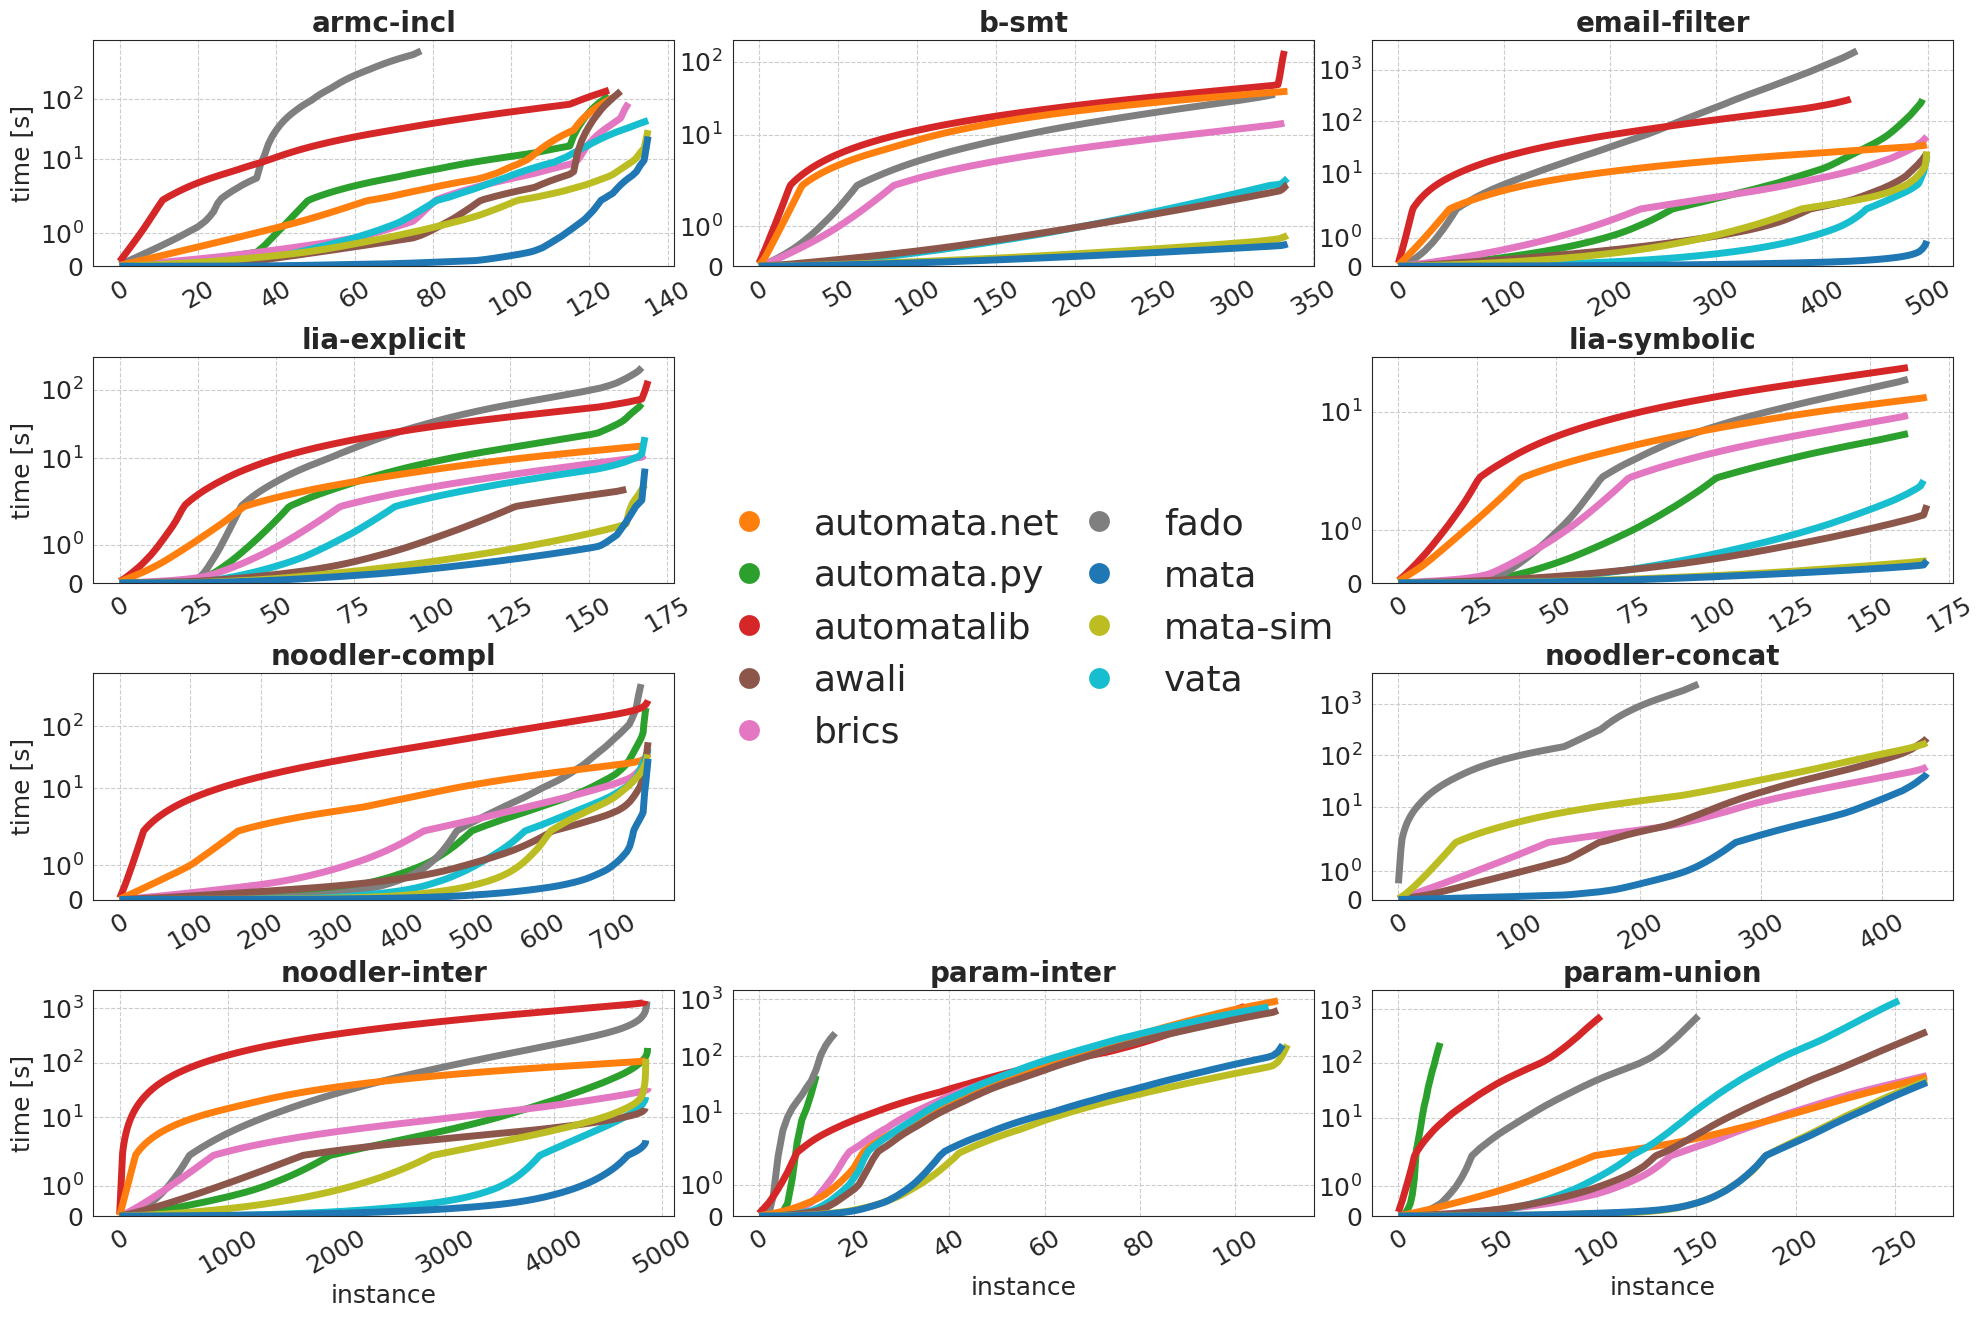

In [12]:
bench_list = sorted(list(set(list(df['bench']))))

item_no = len(bench_list)
item_per_row = 3
x_dim = item_no // item_per_row + 1
y_dim = min(item_no, item_per_row)

mosaic = """
  ABC
  DKE
  FKG
  HIJ
"""

mosaics = "ABCDEFGHIJ"
hr = [1, 1, 1, 1]
log = ""

seaborn.set_style('white', {'axes.grid': True, 'grid.linestyle': '--', 'lines.solid_capstyle': 'butt'})

for sum_op, sum_name in [
    (sum_generator, "sum"), 
]:
    for op in (
        'fairest-of-them-all',
    ):
        #fig, ax = plt.subplots(x_dim, y_dim, figsize=(x_dim * 4, y_dim * 10))
        fig, ax = plt.subplot_mosaic(mosaic, figsize=(x_dim*6, y_dim*4), height_ratios=hr)
        plt.subplots_adjust(top=0.99, bottom=0.01, hspace=0.4, wspace=0.1)
        
        i = 0
        for grp in bench_list:
            series = df[df['bench'] == grp]
            series = series[series['op'] == op]
            grp_name = f"{grp}"
            k = mosaics[i]
            
            idata = {}
            for tool, values in series.groupby('tool'):
                idata[tool] = list(sum_op(values, timeout=TIMEOUT))

            order = ['mata', 'mata-sim', 'awali', 'mona', 'vata',  'automata.net', 'brics', 'automatalib', 'fado', 'automata.py'][::-1]
            data = {}
            for key in order:
                if key not in idata.keys():
                    continue
                data[key] = idata[key]
                    
            g = seaborn.lineplot(
                #data, linewidth=3.5, palette=color_map, dashes="", ax=ax[i // item_per_row, i % item_per_row] if item_no > 1 else ax
                data, linewidth=5, palette=color_map, dashes="", ax=ax[k] if item_no > 1 else ax
            )

            g.legend([], [], frameon=False)
            g.set(yscale=axis_scale)
            g.set_xticklabels(g.get_xticklabels(), rotation=30, fontsize=18)
            g.set_yticklabels(g.get_yticklabels(), fontsize=18)
            g.set_title(
                f"{grp}", 
                weight='bold',
                #x=0.3, 
                fontsize=20
            )
            if k in "ADFH":
                g.set_ylabel("time [s]", fontsize=18)
            if k in "HIJ":
                g.set_xlabel("instance", fontsize=18)
            
            
            x_lim_min, x_lim_max = g.get_xlim()
            g.set_xlim((x_lim_min, x_lim_max))
            y_lim_min, y_lim_max = g.get_ylim()
            g.set_ylim((0, max(y_lim_min, y_lim_max)))
            
            i += 1

        ax["K"].set(xlabel=None)
        ax["K"].set(yticklabels=[])
        ax["K"].set(xticklabels=[])
        ax["K"].set(xticks=[])
        ax["K"].set(yticks=[])
        ax["K"].spines['top'].set_visible(False)
        ax["K"].spines['bottom'].set_visible(False) 
        ax["K"].spines['left'].set_visible(False) 
        ax["K"].spines['right'].set_visible(False) 
        ax["K"].legend(
            handles=[
                Line2D(
                    [0], [0], color='w', marker='o', markerfacecolor=color_map[tool], label=f"{tool}", 
                    markersize=16,
                )
                for tool in sorted(color_map.keys())
            ], ncols=2, loc='center', fontsize='26', frameon=False, columnspacing=0.1
        ) 
        save_figure(f"paper-cactus-plot-per-bench-{sum_name}-{op}-4-x-3")
        save_figure(f"paper-cactus-plot-per-bench-{sum_name}-{op}-4-x-3", ext=".pdf")

available: ['complement', 'concatenation', 'determization', 'emptiness', 'fair-overall', 'fairest-of-them-all', 'inclusion', 'interpretation', 'intersection', 'minterm', 'overall', 'parsing', 'reduce', 'result', 'runtime', 'transform', 'trim', 'union']
Saving to ./data/experiments-10-10-full/figs/paper-cactus-plot-per-operation-sum.png
Saving to ./data/experiments-10-10-full/figs/paper-cactus-plot-per-operation-sum.pdf


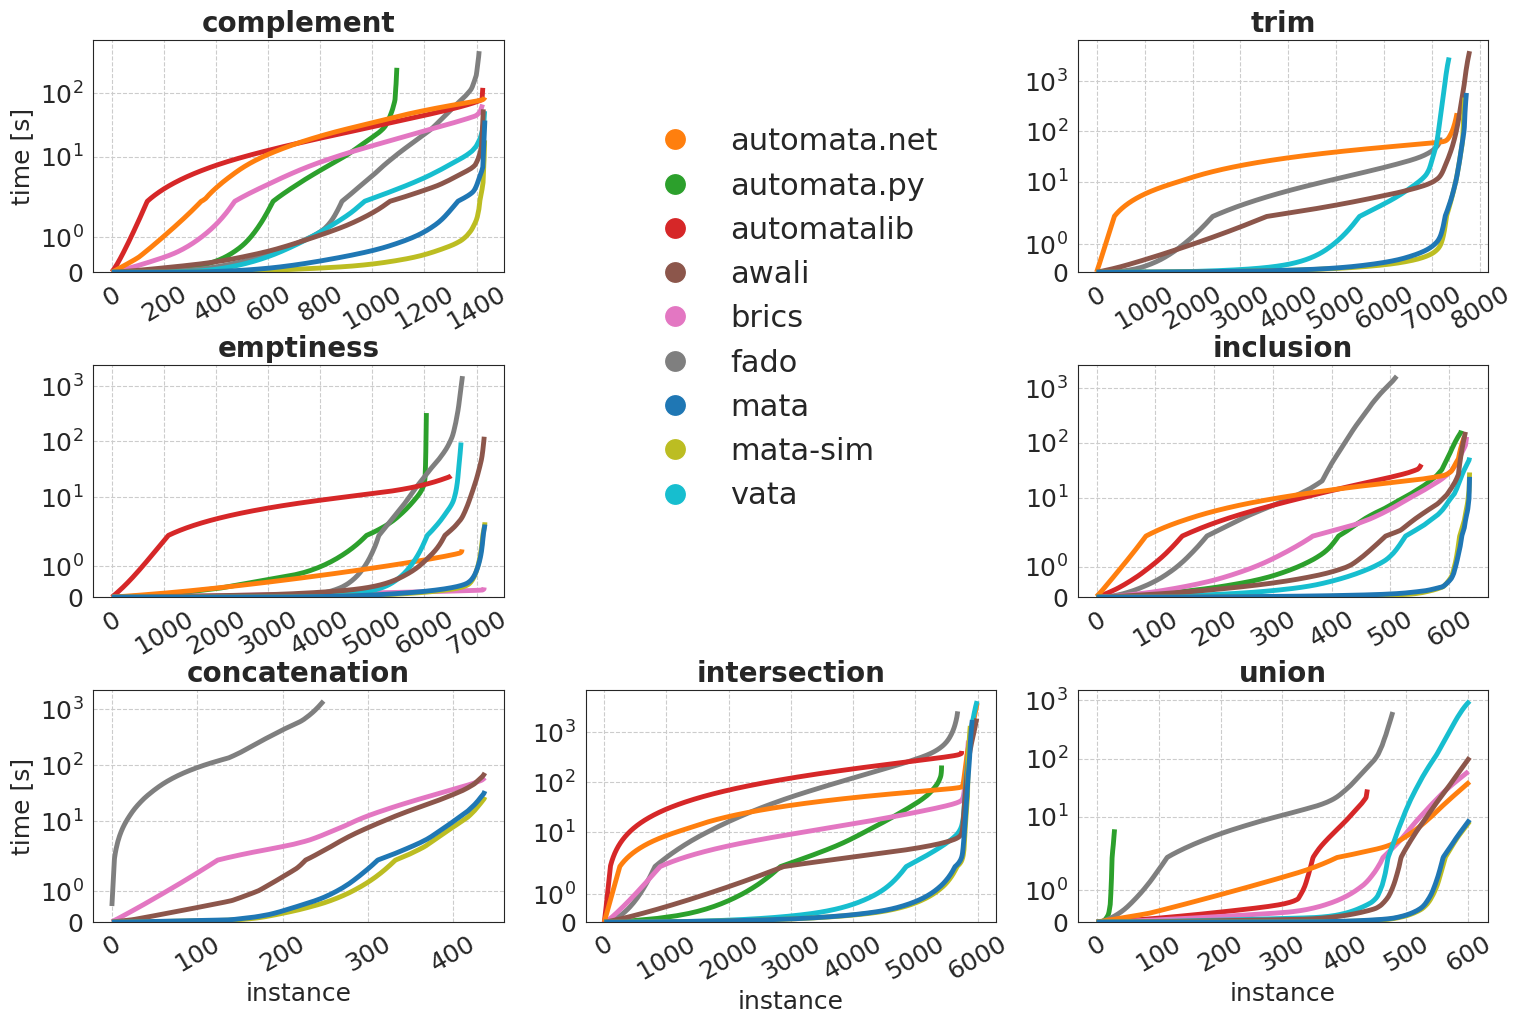

In [13]:
op_list = sorted(list(set(list(df['op']))))
print(f"available: {op_list}")
op_list = [
    'complement',    #'fair-overall',      
    #'fairest-of-them-all',
    'trim', 
    'emptiness',                     'inclusion',
    'concatenation', 'intersection', 'union'
    #'determization',  
    #'overall', 
    #'interpretation', 
    #'minterm', 
    #'parsing', 'reduce', 
    #'runtime', 'transform', 
]
item_no = len(op_list)
x_dim = item_no // 3 + 1
y_dim = min(item_no, 3)

mosaic = """
  AKB
  CKD
  EFG
"""

seaborn.set_style('white', {'axes.grid': True, 'grid.linestyle': '--', 'lines.solid_capstyle': 'butt'})

mosaics = "ABCDEFGHIJ"
hr = [1, 1, 1]

for sum_op, sum_name in [(sum_generator, "sum")]:
    #fig, ax = plt.subplots(x_dim, y_dim, figsize=(x_dim * 5, y_dim * 3))
    fig, ax = plt.subplot_mosaic(mosaic, figsize=(x_dim * 6, y_dim * 3), height_ratios=hr)
    plt.subplots_adjust(top=0.99, bottom=0.01, hspace=0.4, wspace=0.20)
    
    i = 0
    for grp in op_list:
        series = df[df['op'] == grp]
        grp_name = f"{grp}"
        k = mosaics[i]
        
        idata = {}
        for tool, values in series.groupby('tool'):
            idata[tool] = list(sum_op(values, timeout=TIMEOUT))
        order = ['mata', 'mata-sim', 'awali', 'mona', 'vata',  'automata.net', 'brics', 'automatalib', 'fado', 'automata.py'][::-1]
        
        data = {}
        for key in order:
            if key not in idata.keys():
                continue
            data[key] = idata[key]
        g = seaborn.lineplot(
            data, linewidth=3.5, palette=color_map, dashes="", ax=ax[k] if item_no > 1 else ax
        )
        g.legend([], [], frameon=False)
        
        g.set(yscale=axis_scale)
        g.set_xticklabels(g.get_xticklabels(), rotation=30, fontsize=18)
        g.set_yticklabels(g.get_yticklabels(), fontsize=18)
        g.set_title(
            f"{grp}", 
            weight='bold',
            #x=0.05,
            fontsize=20
        )
        if k in "AE":
            g.set_ylabel("time [s]", fontsize=18)
        if k in "EFGH":
            g.set_xlabel("instance", fontsize=18)
        
        #seaborn.move_legend(g, "upper left", bbox_to_anchor=(0., 1), frameon=False)
        x_lim_min, x_lim_max = g.get_xlim()
        g.set_xlim((x_lim_min, x_lim_max))
        y_lim_min, y_lim_max = g.get_ylim()
        g.set_ylim((0, max(y_lim_min, y_lim_max)))

        i += 1


    ax["K"].set(xlabel=None)
    ax["K"].set(yticklabels=[])
    ax["K"].set(xticklabels=[])
    ax["K"].set(xticks=[])
    ax["K"].set(yticks=[])
    ax["K"].spines['top'].set_visible(False)
    ax["K"].spines['bottom'].set_visible(False) 
    ax["K"].spines['left'].set_visible(False) 
    ax["K"].spines['right'].set_visible(False) 
    ax["K"].legend(
        handles=[
            Line2D(
                [0], [0], color='w', marker='o', markerfacecolor=color_map[tool], label=f"{tool}", 
                markersize=16,
            )
            for tool in sorted(color_map.keys())
        ], ncols=1, loc='center', fontsize='22', frameon=False
    ) 
    save_figure(f"paper-cactus-plot-per-operation-{sum_name}")
    save_figure(f"paper-cactus-plot-per-operation-{sum_name}", ext=".pdf")

### Rest of the visualizations

In [14]:
def to_multicol(value, i, size=3):
    cc = 'h' if i % 2 == 0 else 'c'
    return f'\\multicolumn{{{size}}}{{{cc}}}{{{value}}}'

def to_table(df, rows, aggregation, limit_tools, val_size, valid_values=None):
    tools = ['mata', 'mata-0.111', 'mata-0.112', 'mata-0.113', 'mata-old', 'mata-sim', 'awali', 'mona', 'vata',  'automata.net', 'brics', 'automatalib', 'fado', 'automata.py', '(py)mata']
    tools = [t for t in tools if t in set(df['tool']) and t in limit_tools]
    data = {
        grp: [grp] + [to_multicol('-', i, val_size) for i in range(len(tools))] for grp in set(df[rows]) 
        if valid_values == None or grp in valid_values
    }
    for grp, series in df.groupby([rows, 'tool'] if not isinstance(rows, list) else rows + ['tool']):
        if (valid_values != None and grp[0] not in valid_values) or grp[1] not in tools:
            continue
        vals = aggregation(series['time'])
        data[grp[0]][tools.index(grp[1]) + 1] = " & ".join(vals)
    return tabulate.tabulate(
        sorted(data.values()), headers=[
            "\\textbf{operation}" if rows == 'op' else "\\textbf{benchmark}"    
        ] + [
            to_multicol(f"\\textbf{{{t}}}", i, val_size) for i, t in enumerate(tools)
        ], tablefmt='latex_raw'
    )

def save_table(table, filename):
    tgt_dir = os.path.join(DATA_SOURCE, FIGS_DIR)
    tgt = os.path.join(tgt_dir, filename)    
    if not os.path.exists(tgt_dir):
        os.makedirs(tgt_dir)
    with open(tgt, 'w') as table_h:
        lines = table.split('\n')[2:-2]
        lines[1] = '\\midrule'
        #lines = ['\\toprule'] + lines
        lines = lines + ['\\bottomrule']
        table_h.write('\n'.join(lines))
    shutil.copy(tgt, PAPER_DIR)
    print(f"Saved to {tgt}")
    

In [15]:
## Mean, Median Mean with timeouts/errors
def to_cell(val):
    if val == 0:
        return "$\overline{0}$"
    if val < TIMEOUT * 1000: 
        if val >= 1000:
            return f"{int(round(val / 1000, 0))} s"
        else:
            return f"{val}"
    else:
        return f"TO"
def stats(series):
    times = [t for t in series if  (isinstance(t, float) or isinstance(t, int)) and t >= 0 and t < TIMEOUT]
    #timeouts = [t for t in series if ((isinstance(t, float) or isinstance(t, int)) and t >= TIMEOUT)]
    timeouts = [a for a in series if ((isinstance(a, float) or isinstance(a, int)) and (a >= TIMEOUT)) or a == 'ERR']

    times_with_timeout = [t if (isinstance(t, float) or isinstance(t, int)) and t >= 0 else TIMEOUT for t in series]

    mean = int(round(1000 *numpy.mean(times or [60]), 6))
    #first = int(1000 * round(numpy.quantile(times_with_timeout, 0.25), 3))
    first = int(round(1000 * numpy.quantile(times_with_timeout, 0.5), 6))
    #third = int(1000 * round(numpy.quantile(times_with_timeout, 0.75), 3))
    third = int(round(1000 * numpy.std(times), 6))

    if with_to:
        return (
            f"{len(timeouts)}",
            to_cell(mean),
            to_cell(first),
            to_cell(third),
        )
    else:
        return (
            to_cell(mean),
            to_cell(first),
            to_cell(third),
        )
valid_values = [
    'complement', 'trim', 'emptiness', 'inclusion', 'concatenation', 'intersection', 'union'
]

with_to = False
table = to_table(df, 'op', stats, limit_tools=['mata', 'awali', 'vata', 'mona', 'automata.net'], val_size=3, valid_values=valid_values)
print(table)
save_table(table, "stats-per-op-1.tex")
print()
table = to_table(df, 'op', stats, limit_tools=['mata', 'brics', 'automatalib', 'fado', 'automata.py'], val_size=3, valid_values=valid_values)
print(table)
save_table(table, "stats-per-op-2.tex")

\begin{tabular}{lllll}
\hline
 \textbf{operation}   & \multicolumn{3}{h}{\textbf{mata}}   & \multicolumn{3}{c}{\textbf{awali}}   & \multicolumn{3}{h}{\textbf{vata}}   & \multicolumn{3}{c}{\textbf{automata.net}}        \\
\hline
 complement           & 25 & 1 & 315                        & 38 & 2 & 462                         & 36 & 3 & 294                        & 59 & 53 & 76                                     \\
 concatenation        & 78 & 8 & 235                        & 166 & 22 & 402                       & \multicolumn{3}{h}{-}               & \multicolumn{3}{c}{-}                            \\
 emptiness            & $\overline{0}$ & $\overline{0}$ & 2 & 17 & $\overline{0}$ & 138            & 14 & $\overline{0}$ & 130           & $\overline{0}$ & $\overline{0}$ & $\overline{0}$ \\
 inclusion            & 37 & $\overline{0}$ & 576           & 251 & 2 & 2 s                        & 84 & 2 & 372                        & 204 & 41 & 983                                   \\
 interse

In [16]:
with_to = True
table = to_table(df[df['op'] == 'fairest-of-them-all'], 'bench', stats, limit_tools=['mata', 'awali', 'vata', 'mona', 'automata.net'], val_size=4, valid_values=None)
print(table)
save_table(table, "stats-per-bench-1.tex")
print()
table = to_table(df[df['op'] == 'fairest-of-them-all'], 'bench', stats, limit_tools=['mata', 'brics', 'automatalib', 'fado', 'automata.py'], val_size=4, valid_values=None)
print(table)
save_table(table, "stats-per-bench-2.tex")
print()

\begin{tabular}{lllll}
\hline
 \textbf{benchmark}   & \multicolumn{4}{h}{\textbf{mata}}       & \multicolumn{4}{c}{\textbf{awali}}   & \multicolumn{4}{h}{\textbf{vata}}   & \multicolumn{4}{c}{\textbf{automata.net}}   \\
\hline
 armc-incl            & 0 & 174 & 2 & 1 s                       & 7 & 1 s & 17 & 3 s                   & 0 & 324 & 43 & 577                  & 9 & 845 & 60 & 2 s                          \\
 b-smt                & 0 & 1 & 1 & 1                           & 0 & 6 & 6 & 4                        & 0 & 7 & 7 & 10                      & 0 & 117 & 129 & 24                          \\
 email-filter         & 0 & 1 & $\overline{0}$ & 7              & 0 & 47 & 4 & 165                     & 0 & 42 & 2 & 315                    & 0 & 69 & 66 & 30                            \\
 lia-explicit         & 0 & 42 & 6 & 356                        & 6 & 21 & 21 & 16                     & 0 & 121 & 51 & 671                  & 0 & 91 & 88 & 33                            \\
 lia-symbolic

In [17]:
solved_by_fastest = set()
tools = ['mata', 'awali', 'automata.net', 'vata', 'brics']
for grp, series in df.groupby(['input']):
    all_runs = True
    for tool in tools:
        s = series[series['tool'] == tool]
        val = list(s[s['op'] == 'fairest-of-them-all']['time'])
        assert len(val) >= 1
        val = val[0]
        if isinstance(val, int | float) and val < TIMEOUT:
            all_runs = all_runs and True
        else:
            all_runs = all_runs and False
    if all_runs:
        solved_by_fastest.add(grp[0])

AssertionError: 

In [ ]:
def relative_stats(series):
    d = {}
    for k, v in series.iterrows():
        assert v['input'] not in d.keys()
        d[v['input']] = v['time']
    return d
def has_finished(val):
    return isinstance(val, int | float) and 0 < float(val) < TIMEOUT
def compute_relative(mata_d, other_d):
    mata_sum = 0
    other_sum = 0
    for key in mata_d.keys():
        mata_val = mata_d[key]
        other_val = other_d[key]
        if has_finished(mata_val) and has_finished(other_val):
            mata_sum += mata_val
            other_sum += other_val
    return round(other_sum / mata_sum, 2) if mata_sum != 0 else '-'
    
def to_relative_table(df, rows, aggregation):
    tools = ['mata', 'mata-0.111', 'mata-0.112', 'mata-0.113', 'mata-old', 'mata-sim', 'awali', 'mona', 'vata',  'automata.net', 'brics', 'automatalib-old', 'automatalib', 'fado', 'automata.py', '(py)mata']
    tools = [t for t in tools if t in set(df['tool'])]
    data = {
        grp: [grp] + ['-' for i in range(len(tools))] for grp in set(df[rows]) if grp != 'result' and 'result' not in grp
    }
    for grp, series in df.groupby([rows, 'tool'] if not isinstance(rows, list) else rows + ['tool']):
        if grp[0] == 'result' or 'result' in grp[0]:
            continue
        vals = aggregation(series[['time', 'input']])
        data[grp[0]][tools.index(grp[1]) + 1] = vals
    for key, vals in data.items():
        data[key] = [vals[0]] + [
            '-' if val == '-' else f"{compute_relative(vals[1], val)}" for val in vals[1:]
        ]        
    return tabulate.tabulate(
        sorted(data.values()), headers=[rows] + tools, tablefmt='latex'
    )    
with_to = True
cut = df[df['op'] == 'fairest-of-them-all']
table = to_relative_table(cut, 'bench', relative_stats)
print(table)
print()
save_table(table, "stats-relative.tex")

In [ ]:
def some_fucking_stats(series):
    times = [t if (isinstance(t, float | int) and t >= 0 and t < TIMEOUT) else TIMEOUT for t in series]
    return sum(times)
def to_fucking_table(df, rows, aggregation, trim_rows=False, trimsize=5):
    tools = ['mata', 'mata-0.111', 'mata-0.112', 'mata-0.113', 'mata-old', 'mata-sim', 'awali', 'mona', 'vata',  'automata.net', 'brics','automatalib-old', 'automatalib', 'fado', 'automata.py', '(py)mata']
    tools = [t for t in tools if t in set(df['tool'])]
    data = {
        grp: [grp[:trimsize] if trim_rows else grp] + ['-' for i in range(len(tools))] for grp in set(df[rows]) if grp != 'result' and 'result' not in grp
    }
    for grp, series in df.groupby([rows, 'tool'] if not isinstance(rows, list) else rows + ['tool']):
        if grp[0] == 'result' or 'result' in grp[0]:
            continue
        series = series[series['input'].isin(solved_by_fastest)]
        print(grp, len(series['time']))
        vals = aggregation(series['time'])
        data[grp[0]][tools.index(grp[1]) + 1] = vals
    
    for key, vals in data.items():
        print(vals)
        data[key] = [vals[0]] + [
            '-' if val == '-' else f"{round(val / vals[1] if vals[1] != 0 else 0, 2)}" for val in vals[1:]
        ]        
    return tabulate.tabulate(
        sorted(data.values()), headers=[rows] + tools, tablefmt='latex'
    )    
with_to = True
cut = df[df['op'] == 'fairest-of-them-all']
table = to_fucking_table(cut, 'bench', some_fucking_stats)
print(table)
print()

In [ ]:
solved_by_fastest

In [ ]:
print("DONE")

In [ ]:
for grp, ddf in df.groupby('bench'):
    if grp == 'param-union':
        brics = ddf[ddf['tool'] == 'brics']
        ub = brics[brics['op'] == 'fairest-of-them-all']
        times = list(ub['time'])
        print(len(times))
        print([times])